# **SÉRIE TEMPORAL CINETOUR - VIAGEM DE CINEMA**

**Objetivo:** Analisar o padrão de acessos ao blog *Cinetour - Viagem de Cinema* e identificar qual o modelo funciona melhor para fazer predições com eles: o *Auto-Regressive Integrated Moving Average* (ARIMA) ou o *Multilayer Perceptron* (MLP).

## Pacotes e funções necessários

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Coleta e exploração dos dados

**Base de dados:** O blog *Cinetour - Viagem de Cinema* (https://www.cinetourviagemdecinema.com/) publica conteúdo sobre locações de filmes e séries de tevê desde maio de 2010. Ele foi construído usando Blogger, uma plataforma de criação, edição e gestão de blogs de propriedade do Google. Os dados para esse estudo foram coletados diretamente das estatísticas fornecidas por essa plataforma.

**Período da série:** 01/06/2010 - 31/05/2022

In [2]:
VC = pd.read_csv('dados/VC-dados-total.csv', parse_dates=['Meses'], index_col=['Meses'])
VC.head()

,#Acessos
Meses,
2010-06-01,33
2010-07-01,244
2010-08-01,166
2010-09-01,196
2010-10-01,347


In [3]:
VC.describe()

,#Acessos
count,144.000000
mean,7313.875000
std,6147.324646
min,33.000000
25%,3776.750000
50%,5506.000000
75%,8627.500000
max,38726.000000


Comentário: *A quantidade de acessos mensais do período analisado apresentou o mínimo de 33 acessos, em 06/2010, e o máximo de 38.726 acessos, em 08/2016. A média mensal de acessos foi de 7.314, quantidade superior ao da mediana, que foi de 5.506 acessos.*

# **DECOMPOSIÇÃO DA SÉRIE TEMPORAL**

A técnica de *decomposição* será utilizada para podermos examinar tanto a distribuição dos dados do blog ao longo do tempo como se eles mostram algum padrão de:
- **tendência** geral (*trend*), através da captura de mudanças no nível ao longo do tempo;
- **sazonalidade** (*seasonal*), através da captura de efeitos cíclicos de acordo com a época do ano; e
- **resíduos** (*residuals*) ou comportamentos irregulares não descritos pelos efeitos de tendência ou de sazonalidade.

A decomposição dos dados pode ser *aditiva* ou *multiplicativa*.

### Modelo Aditivo
Neste modelo, os componentes são somados para gerar os valores da série temporal e os resíduos são centralizados em torno de 0.

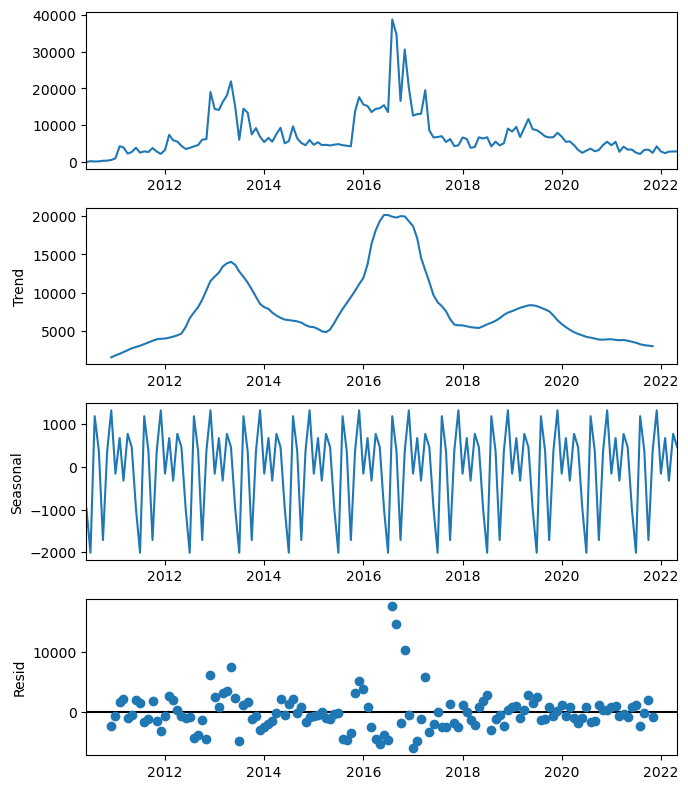

In [4]:
plt.rcParams['figure.figsize'] = [7, 8]

sd = seasonal_decompose(VC, period=12).plot()

Comentários:

- *O primeiro gráfico mostra a distribuição dos dados de acessos ao blog ao longo dos 12 anos analisados.*

- *O gráfico **Trend** indica que não existe uma tendência geral de acessos ao blog, mas flutuações aleatórias ao longo dos anos, com altas em 2013, pico em agosto de 2016 e queda contínua a partir de maio/2017. Em 2019, houve um leve incremento nos acessos, mas, desde então, os dados se estabilizaram numa média mensal de 3.500 acessos. Ou seja, trata-se de uma série temporal com dados complexos, que demandam técnicas avançadas como ARIMA e MLP.*

- *O gráfico **Seasonal** mostra que existe um componente de sazonalidade consistente, que se repete todos os anos.*

- *O gráfico **Resid** mostra as irregularidades existentes nos dados, especialmente os outliers existentes entre 08 e 11/2016.*

### Modelo Multiplicativo
Neste modelo, os componentes são multiplicados para gerar os valores da série temporal e os resíduos são centralizados em torno de 1.

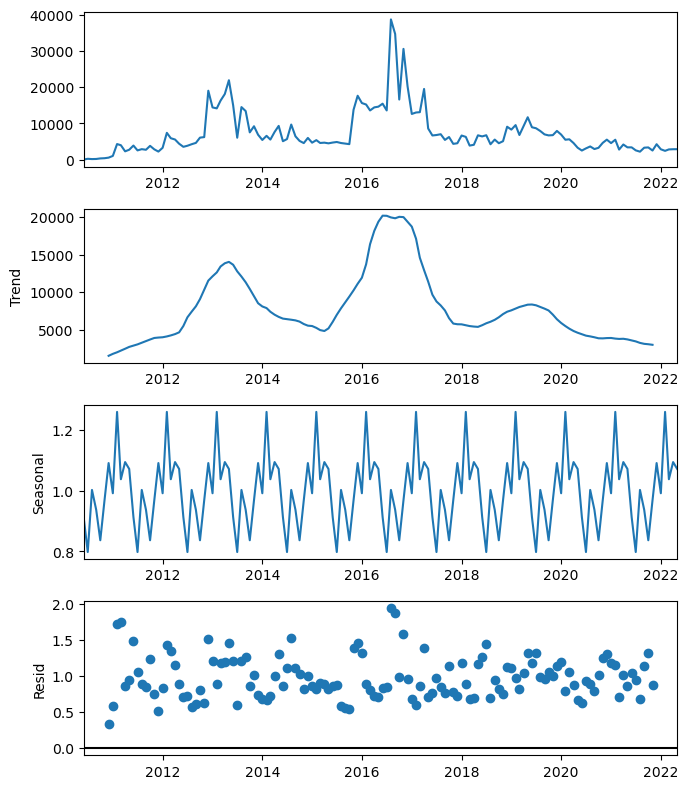

In [5]:
sd = seasonal_decompose(VC, model='multiplicative').plot()

Comentários: 

*As principais diferenças entre esse modelo e o aditivo encontram-se nos gráficos de sazonalidade e resíduos:*
- *No de sazonalidade, com os dados distribuídos em coeficientes entre 0.8 e +1.2, pode-se ver como os padrões tanto de alta como de baixas nos acessos são similares em todos os anos, o que pode ser útil durante o processo de modelagem para previsão de acessos futuros.*
- *O gráfico de resíduos mostra que, independente da mudança na escala de apresentação (coeficientes entre 0.0 e 2.0 e centralização em 1.0), as irregularidades se apresentam em todo o período analisado. O ACF (Função de Autocorrelação) e o teste Ljung-Box mostrarão se esses componentes de irregularidades têm ou não significância estatística.*

# **MODELO 1: ARIMA**

### Separação dos dados em Treino e Teste

- Treino: dados do período de 06/2010 até 05/2021
- Teste: dados do período de 06/2021 até 05/2022

In [6]:
trn = VC.loc[VC.index < '2021-06-01']

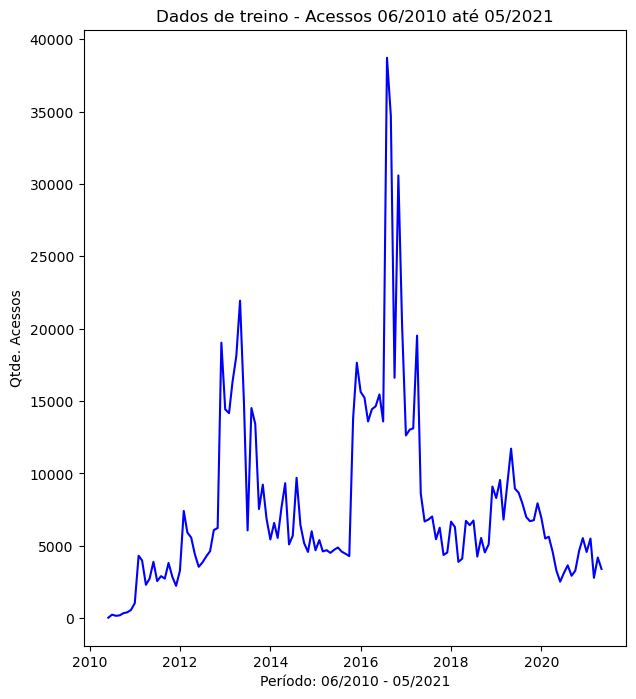

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Período: 06/2010 - 05/2021')
plt.ylabel('Qtde. Acessos')
plt.title('Dados de treino - Acessos 06/2010 até 05/2021')
plt.plot(trn, color='blue')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [8]:
tst = VC.loc[VC.index >= '2021-06-01']

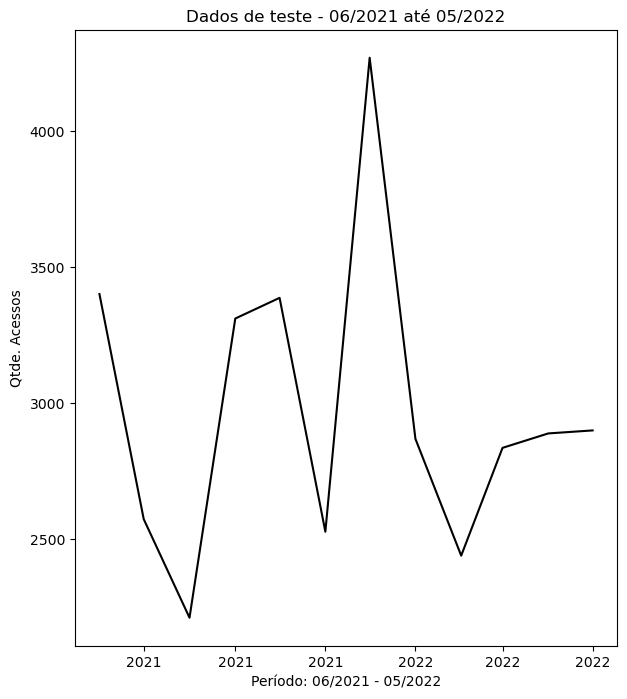

In [9]:
fig, ax = plt.subplots()
plt.xlabel('Período: 06/2021 - 05/2022')
plt.ylabel('Qtde. Acessos')
plt.title('Dados de teste - 06/2021 até 05/2022')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Preparação dos dados para aplicação do ARIMA

- O ARIMA requer dados não estacionários, em que média, variância e/ou covariância variam ao longo do tempo.
- Os dados não estacionários mostram correlações significativas quando são defasados; *quanto mais próximos de 0, melhor*.
- O teste de estacionaridade da série será feito usando Função de Autocorrelação (ACF).

#### Usando **ACF** (*Autocorrelation Function* ou Função de Autocorrelação)

- ACF é uma medida da correlação entre as observações de uma série temporal separadas por k unidades de tempo chamadas de *lag*, mostrando como elas se autocorrelacionam quando são defasadas. 
- O eixo horizontal indicará a defasagem dos dados da série (que será de 48 meses ou lags).
- O eixo vertical indicará a autocorrelação entre os lags (lembrando que, quanto mais próximo de 0, melhor para o ARIMA).

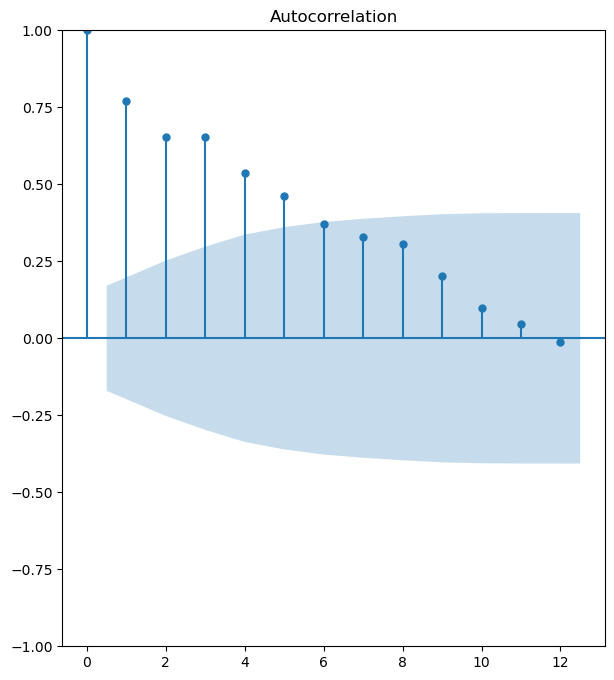

In [10]:
trn_acf2 = plot_acf(trn, lags=12)

Comentários: 

- *Os valores dos lags 1 ao 6 (no espaço branco) são altamente correlacionados.*
- *Há um pico no lag 1 que diminui ao longo de vários períodos até o lag 19. Nota-se que, mesmo quando voltam a subir, os valores permanecem dentro dos limites da faixa azul, onde a autocorrelação é igual ou próxima de 0, significando que essa série é aleatória, de dados não estacionários, como é esperado pelo ARIMA.*

#### Usando **Regressão Linear** como base de comparação para o ARIMA

- A variável dependente é o número de acessos.
- A variável independente será uma tendência temporal linear.
- O intervalo de confiança será de 95%.

In [11]:
lr = sm.OLS(endog=trn['#Acessos'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit() 

y_hat = lr.fittedvalues

y_ci = lr.get_prediction().conf_int(alpha=0.05)

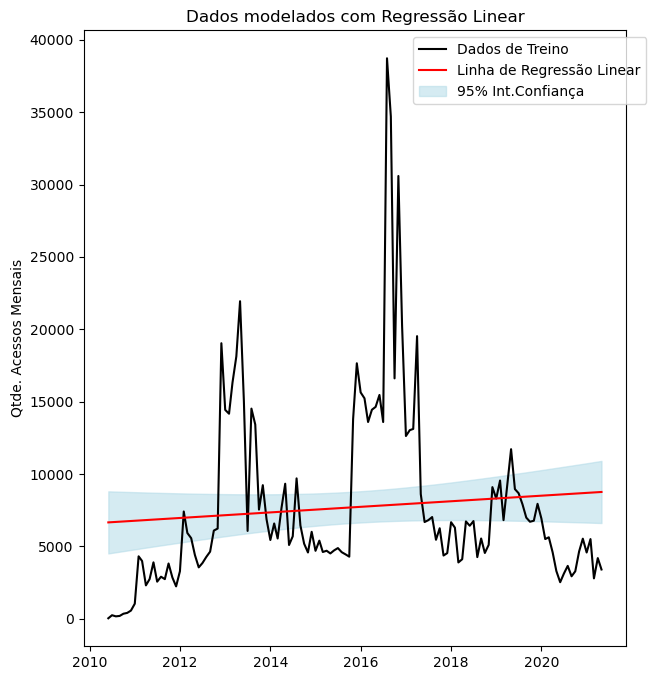

In [12]:
fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos Mensais')
plt.title('Dados modelados com Regressão Linear')
plt.plot(trn, color='black', label='Dados de Treino')
plt.plot(y_hat, color='red', label='Linha de Regressão Linear')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Int.Confiança')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

Comentário: *A linha de regressão linear (em vermelho) e o intervalo de confiança (em azul) mostram que as sazonalidades da série não estão sendo capturadas por esse modelo. Agora, usaremos o ARIMA para ver se ele consegue capturar isso.*

### Treinamento dos dados com o ARIMA

- Os parâmetros ótimos do modelo serão encontrados usando a função `auto_arima` do pacote `pmdarima`.
- Por padrão, o período de sazonalidade 'm' é igual a 1. Usando m=12 assegura-se que o modelo levará em consideração a sazonalidade anual observada na série temporal (ou seja, um ciclo a cada 12 meses).
- O modelo será construído com o algoritmo SARIMAX (*Seasonal Auto-Regressive Integrated Moving Average with Exogenous Factors*), uma variação do ARIMA.

In [13]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
auto_arima_model.order

(3, 0, 1)

Os parâmetros ótimos do modelo são 3, 0, 1, sendo:
- 3 = p: Auto-regressive (AR)   
- 0 = d: Integrate (I)
- 1 = q: Moving average (MA)

In [14]:
auto_arima_model.seasonal_order

(0, 0, 0, 12)

Os padrões sazonais ótimos são 0, 0, 0, 12, sendo:    
- 0 = P: Auto-regressive (AR)
- 0 = D: Integrate (I)    
- 0 = Q: Moving average (MA)   
- 12= M: Sazonalidade

#### Aplicando o Auto_Arima e ACF sobre os dados resíduals

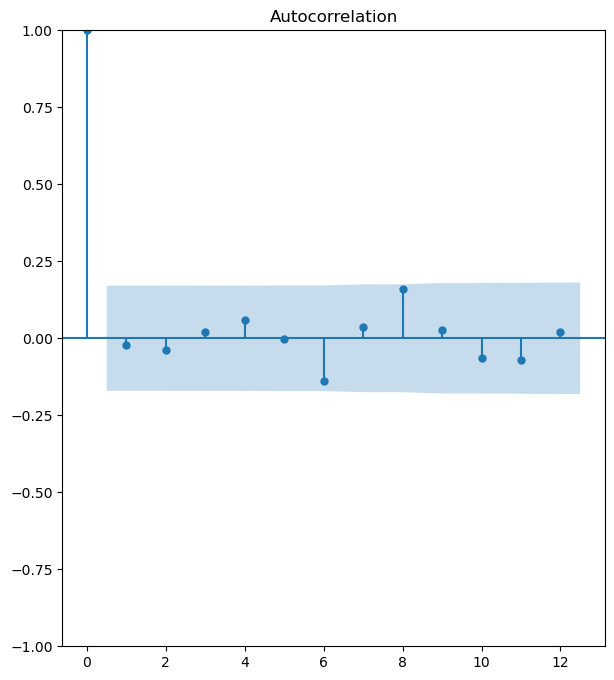

In [15]:
resid = auto_arima_model.resid()

res_acf = plot_acf(resid, lags=12)

Comentário: *Depois do primeiro mês, os resíduos cairam na faixa azul, região de não significância estatística.*

#### Aplicando o teste Ljung-Box sobre os dados resíduais

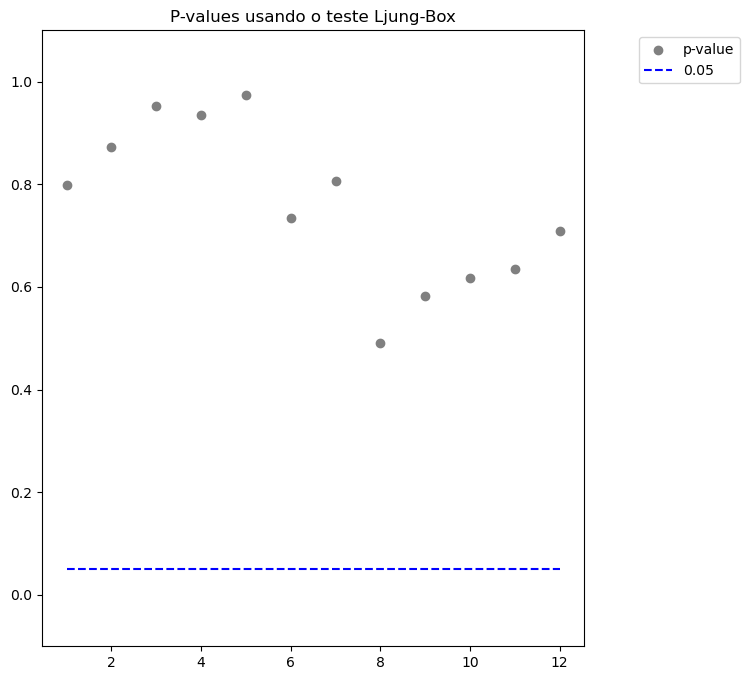

In [16]:
res_lb = acorr_ljungbox(resid, lags=12, return_df=False)[1]

fig, ax = plt.subplots()
plt.title('P-values usando o teste Ljung-Box')
plt.scatter(np.arange(1, 1 + len(res_lb)), res_lb, color='gray', label='p-value')
plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.3, 1))

Comentário: *Os p-values dos valores residuais estão muito acima de 0.05, ou seja, não têm significância estatística, que é o que estamos procurando aqui.*

### Construindo o modelo com os melhores parâmetros

In [17]:
auto_arima_model.fit(trn)

arima_predictions = auto_arima_model.predict(n_periods=12, alpha=0.05, return_conf_int=True)

y_pred = pd.Series(arima_predictions[0], index=tst.index)

y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

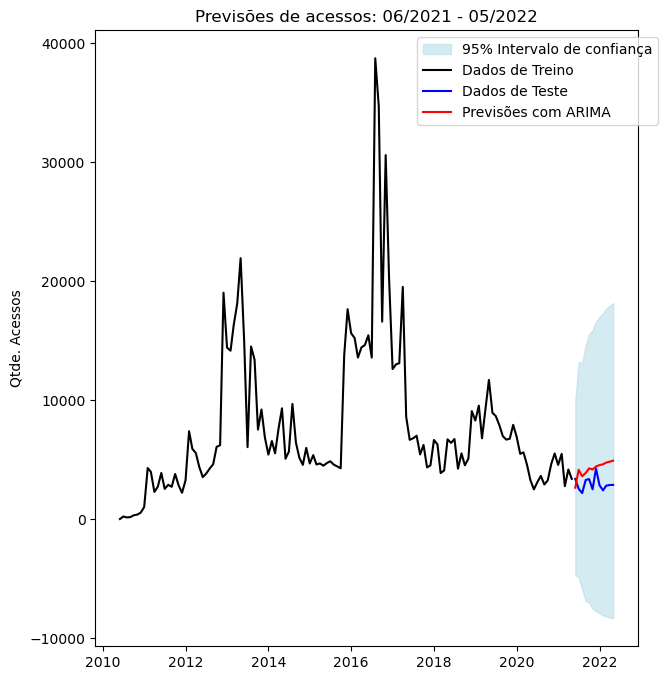

In [18]:
fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos: 06/2021 - 05/2022')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Intervalo de confiança')
plt.plot(trn, color='black', label='Dados de Treino')
plt.plot(tst, color='blue', label='Dados de Teste')
plt.plot(y_pred, color='red', label='Previsões com ARIMA')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

Comentário: *O modelo criado com o ARIMA mostrou que tem capacidade de tratar dados complexos. No entato, esse em particular, aparenta tanto sofrer de underfitting (vide linha vermelha) como ter contemplado toda a variância da série (vide espaço azul claro com o intervalos de confiança), dificultando a sua generalização para novos dados.

### Valores previstos dentro dos intervalos de confiança

In [19]:
tst_pred = pd.DataFrame({
    'Realizado': tst.iloc[:, 0].values, 
    'Previsto': y_pred.values, 
    'Abaixo 95': y_pred_lb,
    'Acima 95': y_pred_ub
    }, index=tst.index)

tst_pred.head(12)

,Realizado,Previsto,Abaixo 95,Acima 95
Meses,,,,
2021-06-01,3400,2663.623804,-4662.952028,9990.199635
2021-07-01,2573,4168.926222,-4882.849998,13220.702443
2021-08-01,2211,3630.028906,-5895.651916,13155.709727
2021-09-01,3310,3898.160824,-6847.559707,14643.881354
2021-10-01,3386,4287.015290,-6972.257243,15546.287823
2021-11-01,2527,4192.385463,-7501.913905,15886.684831
2021-12-01,4268,4441.785911,-7714.464046,16598.035869
2022-01-01,2868,4565.140791,-7870.434478,17000.716061
2022-02-01,2439,4627.448741,-8072.997128,17327.894611


Comentário: *Os valores acima mostram os valores previstos, bem como as estimativas de valores mínimos e valores máximos mensais. Para que tais valores pudessem ser alcançados, a gestão do blog teria que considerar investimentos em campanhas de marketing simultâneas em diferentes mídias tal como fez nos meses de picos de 2016 e 2017.*

# **MODELO 2: MLP**

### Tratamento e separação dos dados

- Reformulando os dados em uma matriz `n x (k + 1)`, onde `n` é o nº de amostras e `k` é o nº de características.

In [20]:
# Capturando um ciclo sazonal completo
k = 12

In [21]:
# As primeiras colunas de `Z` são os lags, e a última, o target
Z = []

for i in range(k + 1, VC.shape[0] + 1):
    Z.append(VC.iloc[(i - k - 1): i, 0])

Z = np.array(Z)

Z.shape

(132, 13)

### Dados de Treino e de Teste
- Treino: 80% dos dados
- Teste: 20% dos dados

In [22]:
split = np.int(0.8 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

In [23]:
scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

## Treinamento dos dados e identificação do melhor nº de hidden nodes

In [24]:
split_ = np.int(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_, :], y_train[:split_]
X_valid_, y_valid_ =  X_train[split_:, :], y_train[split_:]

def validation_loss(hidden_neurons):
        
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
    
    mlp.fit(X_train_, y_train_)

    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

params = [5, 10, 15, 20, 25, 50, 75, 100]
mse = [validation_loss(p) for p in params]

params[np.argmin(mse)]

15

### Treinando e testando o modelo com 15 hidden nodes

In [25]:
mlp = MLPRegressor(hidden_layer_sizes=(15,), max_iter=500, random_state=1, shuffle=False)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

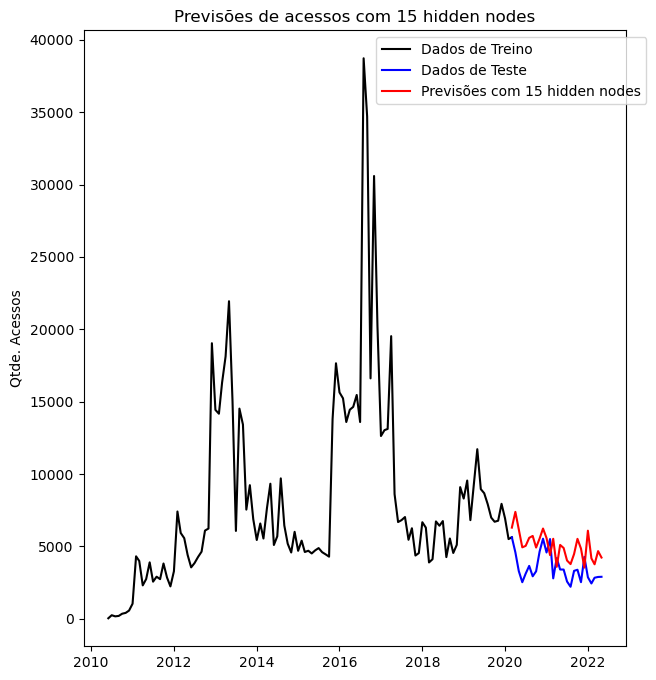

In [26]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos com 15 hidden nodes')
plt.plot(VC.iloc[:(k + len(y_train) + 1), :], color='black', label='Dados de Treino')
plt.plot(pd.Series(y_test_, index=VC.index[-len(y_test):]), color='blue', label='Dados de Teste')
plt.plot(pd.Series(y_pred_, index=VC.index[-len(y_test):]), color='red', label='Previsões com 15 hidden nodes')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

Comentário: *O MLP treinado com 15 hidden nodes apresentou um resultado excelente para essa série temporal, com ajuste quase perfeito aos dados. A observação aqui seria entender se ele pode ser usado com dados novos ou se sofreu de overfitting.*

## Treinamento usando Validação Cruzada 

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

def cross_validation_loss(hidden_neurons):
    
    mse = []
    
    for train_split_, valid_split_ in tscv.split(X_train):
        
        X_train_, y_train_ = X_train[train_split_], y_train[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], y_train[valid_split_] 
        
        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
        
        mlp.fit(X_train_, y_train_)
        
        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))
        
    return np.mean(mse)

In [28]:
params = [5, 10, 15, 20, 25, 50, 75, 100]
mse = [cross_validation_loss(p) for p in params]

params[np.argmin(mse)]

10

### Treinando e testando o modelo com validação cruzada = 5 e hidden nodes = 10

In [29]:
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=1, shuffle=False)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

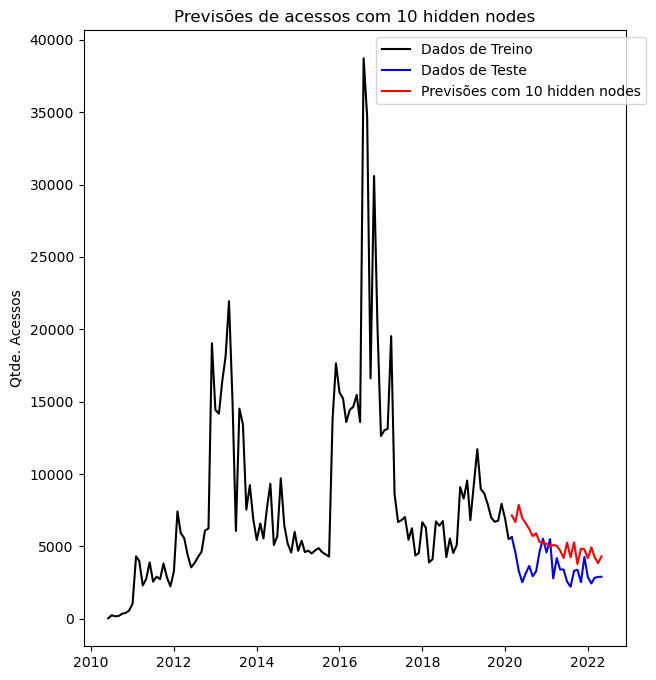

In [30]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.ylabel('Qtde. Acessos')
plt.title('Previsões de acessos com 10 hidden nodes')
plt.plot(VC.iloc[:(k + len(y_train) + 1), :], color='black', label='Dados de Treino')
plt.plot(pd.Series(y_test_, index=VC.index[-len(y_test):]), color='blue', label='Dados de Teste')
plt.plot(pd.Series(y_pred_, index=VC.index[-len(y_test):]), color='red', label='Previsões com 10 hidden nodes')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

Comentário: *O modelo com validação cruzada e 10 hidden nodes também apresentou um bom resultado.*

**Conclusões**: 

*Tanto o modelo criado com ARIMA como os dois criados com o Multilayer Perceptron mostraram que podem contemplar a complexidade dos dados dessa série temporal e fazer boas previsões com eles. Ou seja, qualquer um deles poderia ser usado pela gestão do blog Viagem de Cinema para prever dados futuros, dependendo do objetivo de negócio a ser alcançado.*

*No entanto, algumas observações precisam ser consideradas em relação às duas técnicas:*
- *No caso do ARIMA, como o seu invervalo de confiança abrangeu quase toda a irregularidade dos dados, isso levou a valores extremos, o que dificultaria escolher uma previsão adequada sem contemplar outras decisões de negócios, como campanhas de marketing para o período, por exemplo.*
- *No caso dos dois modelos feitos com o Multilayer Perceptron, ambos se ajustaram muito melhor aos dados dessa série temporal do que o do ARIMA. O ponto a observar seria saber se eles sofreram ou não de overfitting e se são modelos que pode ser generalizados para dados novos.*

*De qualquer forma, ambas técnicas mostraram que, com os ajustes certos em seus hiperparâmetros, elas podem ser efetivas na modelagem de dados complexos em termos de tendência, sazonalidade e ruídos.*